# Bayesian A/B Testing


## Hypothetical Scenario 

In our hypothetical example, we will pretend we are a small team of statisticians at the Office of Inspector General (OIG), tasked with auditing for financial fraud and taxpayer fund misuse. The team has two methods of auditing the financial practices of the Department of Veterans Affairs: on-site audits or desk audits. Desk audits are cheaper, but are they more effective? 

1. **Program A**: Auditors conduct on-site physical audits at the locations under investigation. Our past data shows that **9 out of 60 (15%)** audits resulted in fraud. This is the *observed frequency* of program A uncovering fraud. It's not necessarily the *true frequency* or the *true probability* that program A uncovers fraud since these data are a sample. The data do not consider the plausible alternative audits under program A that could have occurred but did not. In other words, there is a lot of uncertainty in our data. 


2. **Program B**: Auditors conduct desk audits, where all work is conducted from the home office with no physical presence at the location under investigation. Our past data shows that **4 out of 35 (13%)** audits resulted in fraud.

## Our Goals

We want to express the uncertainty of our beliefs regarding the differences in fraud detection rate of program A and program B. The fraud detection rates of each program are defined as parameters:

* $p_A$: program A's fraud detection rate
* $p_B$: program B's fraud detection rate 


While we can clearly see some differences in the observed data upon first glance, the data available to us are highly uncertain quantities. We want to model this uncertainty to infer the most likely true probabilities of fraud under programs A and B. By doing so, we can make intuitive statements such as:

"*There's an X% probability that program A is more effective than program B due to its higher fraud rate.*" 

or 

"*We are 95% confident that program A's fraud detection rate could be anywhere from Y% to Z% better than program B's.*"

## A Bayesian Approach

A Bayesian inference approach to statistics allows us to carry out the above goals by generating samples from probability distributions as outputs. To do so, we need a distribution for prior beliefs about program A and B, our data for program A and B (to model a generative likelihood function), and combine these to arrive at posterior beliefs (updating original beliefs after observing data) about their respective fraud detection rates.

\begin{align}
 P( RateOfFraud | X ) = & \frac{ P(X | RateOfFraud) P(RateOfFraud) } {P(X) } \\\\[5pt]
& \propto P(X | RateOfFraud) P(RateOfFraud)\;\; (\propto \text{is proportional to })
\end{align}


* P( RateOfFraud | X ): **the posterior distribution about the parameter**, which is the probability of our parameter after conditioning on the data and prior. 



* P(X | RateOfFraud): **the likelihood of the data.** A generative model (likelihood function) describing the plausibility of the observed data for every possible parameter values of the RateOfFraud.



* P(RateOfFraud): **the prior credibility of the parameter**. It is the initial plausibility value assigned to each possible parameter value.


* P(X): the probability of the data. The denominator is a normalizing constant that ensures that the numerator of bayes theorem integrates to 1 so that probability estimates are returned. It's the sum of the product of all possible combinations of the likelihood and prior components.



## Uniform Prior Beliefs

Under these assumptions, we'll assume that all probabilities from 0 to 1 are equally likely for program A's and program B's fraud rates. That means that before seeing the data, a 0% fraud rate was just as plausible as 50% and 100% for either program A or B. Probably unrealistic, but it's a stand in to start from. 

In [179]:
# https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline/43028034
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize


def binomial_grid_approx(successes, n_trials, grid_length=100):
    """Estimate the posterior distribution of set of 
    observations that can be modeled as a binomial distribution 
    Use grid approximation. Assume a uniform prior."""
    
    # define grid of possible values of p
    p_grid = np.linspace(0, 1, grid_length)
    # define a uniform prior distribution
    prior = np.ones(grid_length)/grid_length
    # calculate the prob mass function, given different values of p. 
    likelihood = stats.binom.pmf(successes, n_trials, p_grid) 
    # estimate the posterior distribution: P(data | p_grid) * P(p_grid)
    unnormalized_posterior = likelihood * prior # vectorized math

    posterior = unnormalized_posterior / unnormalized_posterior.sum()
    
    return p_grid, posterior

Now run the function over the 2 observed datasets to return posterior probability distributions for program A and program B's fraud rates. 

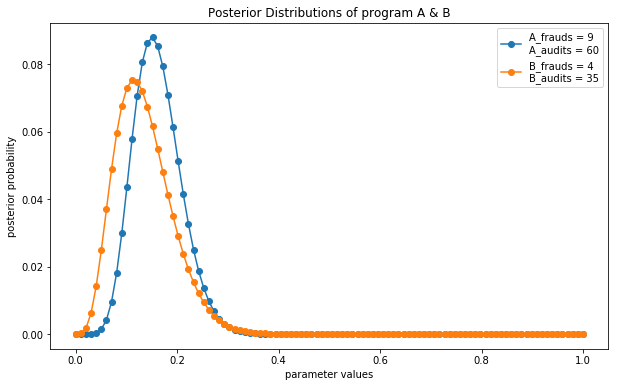

In [95]:
figsize(10, 6)

# observed data
A_fraud, A_audits = 9, 60
B_fraud, B_audits = 4, 35

p_grid, posterior_A = binomial_grid_approx(A_fraud, A_audits, 100)
p_grid, posterior_B = binomial_grid_approx(B_fraud, B_audits, 100)


plt.plot(p_grid, posterior_A, 'o-', label='A_frauds = {}\nA_audits = {}'.format(A_fraud, A_audits))
plt.plot(p_grid, posterior_B, 'o-', label='B_frauds = {}\nB_audits = {}'.format(B_fraud, B_audits))
plt.title('Posterior Distributions of program A & B')
plt.ylabel('posterior probability')
plt.xlabel('parameter values')
plt.legend(loc=0)
plt.show()

The above grid approximation approach produces an analytical posterior probability distributions over our **2 parameters of interest**:

* $p_A$: program A's fraud detection rate
* $p_B$: program B's fraud detection rate 

In order to compare these posterior probability distributions to each other, we should draw sample values from each of them, then count and compare their frequencies over different intervals (*a practical way to calculate integrals*. See Statistical Rethinking Ch.2). Do so will enable us to answer specific probability questions about the data by simply counting frequencies!

## Generate Samples from the Posterior 

Imagine we draw 10,000 samples from of program A's posterior distribution, $p_A$. We can think of each sample being drawn from a bucket that's filled with **parameter values** that exist proportionally to $p_A$'s posterior distribution graphed above. For instance, about 9% of the values to pick out of the bucket will have a sample value of $p_A$ = 16%, the mode of program A's posterior distribution. **The key takeaway is that if we sample a large enough number of times from the posterior, the sample parameter values will appear proportionally to the exact posterior distribution.** All remaining data analysis then simply becomes a matter of tallying frequencies to arrive at probabilistic inferences.

In [76]:
np.random.seed(123)
post_samples_A = np.random.choice(p_grid, size=10000, replace=True, p=posterior_A)
post_samples_B = np.random.choice(p_grid, size=10000, replace=True, p=posterior_B)
post_samples_diff = post_samples_A - post_samples_B

## Use the Samples to Generate Summary Statistics and Answer  Questions

Generating and then graphing 10,000 samples from the posterior distributions of $p_A$ and $p_B$, we've simply replicated the original graph from before, but now we have an array of data points of specific sample values of $p_A$ and $p_B$ to conduct easy data analysis for inference.


### Which range of parameter values for $p_A$ and $p_B$ contains most of the probability mass?

For instance, using posterior samples, the below graphs are able to identify the [**90% highest density interval (HDI)**](https://en.wikipedia.org/wiki/Credible_interval), which is the narrowest interval between which 90% of the most plausible values (highest density) of $p_A$ and $p_B$ exist, given the data and our priors. 

**We clearly see that $p_A$ and $p_B$'s HDI regions are comparable and wide, reflecting the observed data and the increased uncertainty from having very small data samples!** Additionally, we see less of a peak around $p_B$'s central tendency because there are almost half the sample data points from program B as program A indicating even more uncertainty for $p_B$'s true central tendency. More observed data would yield tighter intervals.

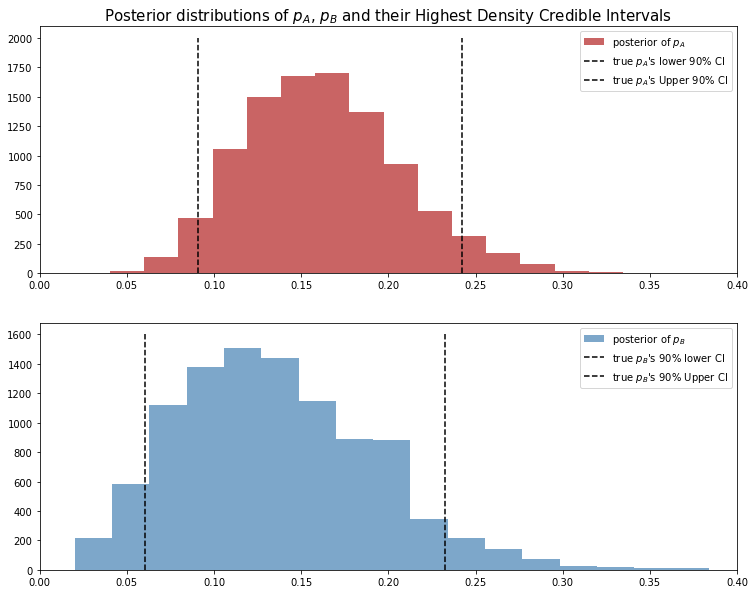

In [136]:
figsize(12.5, 10)

ax = plt.subplot(211)

plt.xlim(0, 0.4)
plt.hist(post_samples_A, histtype='stepfilled', bins = 17, alpha=0.7,
         label="posterior of $p_A$", color="firebrick", density=False)
plt.vlines(np.percentile(post_samples_A, 5), 0, 2000, linestyle="--", label="true $p_A$'s lower 90% CI")
plt.vlines(np.percentile(post_samples_A, 95), 0, 2000, linestyle="--", label="true $p_A$'s Upper 90% CI")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$ and their Highest Density Credible Intervals", fontsize=15)

ax = plt.subplot(212)

plt.xlim(0, 0.4)
plt.hist(post_samples_B, histtype='stepfilled', bins = 17, alpha=0.7,
         label="posterior of $p_B$", color="steelblue", density=False)
plt.vlines(np.percentile(post_samples_B, 5), 0, 1600, linestyle="--", label="true $p_B$'s 90% lower CI")
plt.vlines(np.percentile(post_samples_B, 95), 0, 1600, linestyle="--", label="true $p_B$'s 90% Upper CI")
plt.legend(loc="upper right")
plt.show()

### Given the data, what's the probability that program A has a higher fraud detection rate than program B?

Having generated 10,000 samples from $p_A$ and $p_B$'s posterior distributions, answering this becomes trivial. We just need to tally the proportion of samples from $p_A$'s posterior that are higher than $p_B$'s posterior distribution.

Graphically, this is expressed by calculating the difference between $p_A$ - $p_B$ and observing how many of those differences are above 0. From the answer below, it's pretty clear that given the data, we cannot conclude with high probability that program A is more effective than program B. 

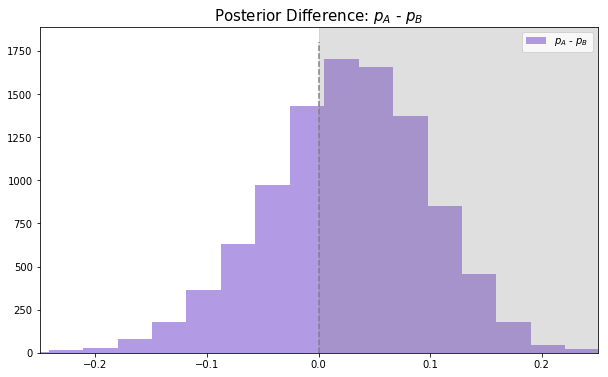

There is only a 63.0% probability that program A has a higher fraud rate than program B


In [139]:
figsize(10, 6)

plt.xlim(-0.25, 0.25)
plt.hist(post_samples_diff, histtype='stepfilled', bins = 18, alpha=0.7,
         label="$p_A$ - $p_B$", color="mediumpurple", density=False)
plt.vlines(0, 0, 1800, linestyle="--", colors='grey')
plt.axvspan(0, 0.25, alpha=0.25, color='grey') # https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
plt.title("Posterior Difference: $p_A$ - $p_B$", fontsize=15)
plt.legend(loc="upper right")
plt.show()

prob = round(100 * np.mean(post_samples_A > post_samples_B))
print('There is only a {}% probability that program A has a higher fraud rate than program B'.format(prob))

### How different is program A's fraud detection rate from program B's fraud detection rate at 90% confidence?

Having generated 10,000 samples of $p_A$ - $p_B$'s, since these data are Gaussian-like distributed, we simply need to identify the middle 95% of $p_A$ - $p_B$ probability mass.

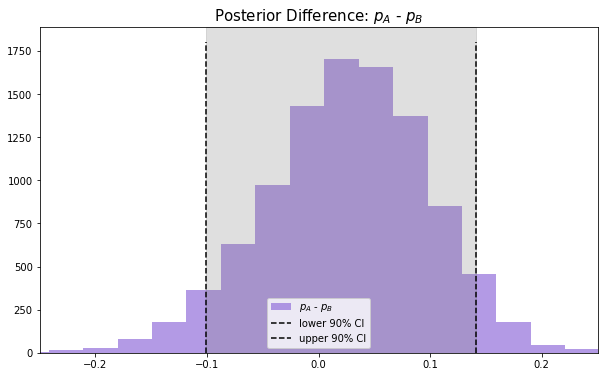

We are 90% confident that program A's fraud detection rate is anywhere from -10% less to 14% higher than program B


In [178]:
CI_95 = (np.percentile(post_samples_diff, 5), np.percentile(post_samples_diff, 95))

figsize(10, 6)

plt.xlim(-0.25, 0.25)
plt.hist(post_samples_diff, histtype='stepfilled', bins = 18, alpha=0.7,
         label="$p_A$ - $p_B$", color="mediumpurple", density=False)
plt.vlines(CI_95[0], 0, 1800, linestyle="--", label="lower 90% CI")
plt.vlines(CI_95[1], 0, 1800, linestyle="--", label="upper 90% CI")
plt.axvspan(CI_95[0], CI_95[1], alpha=0.25, color='grey') # https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
plt.title("Posterior Difference: $p_A$ - $p_B$", fontsize=15)
plt.legend(loc="lower center")
plt.show()

# 10% type I error rate.
print("We are 90% confident that program A's fraud detection rate is anywhere from {:.0f}% less to {:.0f}% higher than program B".format(100 * CI_95[0], 100 * CI_95[1]))